## MultiTemporalCrop Example

In [ ]:
!pip install git+https://github.com/IBM/terratorch.git

In [3]:
import os
import sys
import numpy as np
import torch

import terratorch
from terratorch.datamodules import MultiTemporalCropClassificationDataModule
from terratorch.tasks import SemanticSegmentationTask
from terratorch.datasets.transforms import FlattenTemporalIntoChannels, UnflattenTemporalFromChannels

import albumentations
from albumentations import Compose, Flip
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

If you have the data already downloaded, update the `DATASET_PATH`. Otherwise, download it with the following code. Check [here](https://huggingface.co/datasets/ibm-nasa-geospatial/multi-temporal-crop-classification) for more details on this dataset.

In [4]:
DATASET_PATH = "./data"

In [5]:
from huggingface_hub import snapshot_download

repo_id = "ibm-nasa-geospatial/multi-temporal-crop-classification"
# _ = snapshot_download(repo_id=repo_id, repo_type="dataset", cache_dir="./cache", local_dir=DATASET_PATH)

In [6]:
OUT_DIR = "./multicrop_example"  # where to save checkpoints and log files

BATCH_SIZE = 16
EPOCHS = 50
LR = 2.0e-4
WEIGHT_DECAY = 0.1
HEAD_DROPOUT=0.1
FREEZE_BACKBONE = False

BANDS = ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"]
NUM_FRAMES = 3

CLASS_WEIGHTS = [
    0.386375, 0.661126, 0.548184, 0.640482, 0.876862, 0.925186, 3.249462, 
    1.542289, 2.175141, 2.272419, 3.062762, 3.626097, 1.198702
]

SEED = 0

#### Exploring the dataset

In [7]:
# Adding augmentations for a temporal dataset requires additional transforms
train_transforms = [
    terratorch.datasets.transforms.FlattenTemporalIntoChannels(),
    albumentations.Flip(),
    albumentations.pytorch.transforms.ToTensorV2(),
    terratorch.datasets.transforms.UnflattenTemporalFromChannels(n_timesteps=NUM_FRAMES),
]

In [8]:
# This datamodule allows access to the dataset in its various splits.
data_module = MultiTemporalCropClassificationDataModule(
    data_root=DATASET_PATH,
    train_transform=train_transforms,
    expand_temporal_dimension=True,
)

In [9]:
# Checking the dataset means and stds
data_module.means, data_module.stds

([494.905781, 815.239594, 924.335066, 2968.881459, 2634.621962, 1739.579917],
 [284.925432, 357.84876, 575.566823, 896.601013, 951.900334, 921.407808])

In [10]:
# Checking train split size
data_module.setup("fit")
train_dataset = data_module.train_dataset
len(train_dataset)

3083

In [11]:
# Checking available bands
train_dataset.all_band_names

('BLUE', 'GREEN', 'RED', 'NIR_NARROW', 'SWIR_1', 'SWIR_2')

In [12]:
# Checking dataset classes
train_dataset.class_names

('Natural Vegetation',
 'Forest',
 'Corn',
 'Soybeans',
 'Wetlands',
 'Developed / Barren',
 'Open Water',
 'Winter Wheat',
 'Alfalfa',
 'Fallow / Idle Cropland',
 'Cotton',
 'Sorghum',
 'Other')

In [17]:
train_dataset[0]["image"].shape

torch.Size([6, 3, 224, 224])

In [39]:
from PIL import Image
import rasterio

myimg_path = "../data/54.tif"
# load a tif file
with rasterio.open(myimg_path, "r") as myimg:
    data = myimg.read()

# get the metadata
metadata = myimg.meta

data.shape

(18, 759, 498)

In [ ]:
# Ploting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [18]:
# Checking validation split size
val_dataset = data_module.val_dataset
len(val_dataset)

771

In [19]:
# Checking test split
data_module.setup("test")
test_dataset = data_module.test_dataset
len(test_dataset)

771

#### Training setup

In [20]:
pl.seed_everything(SEED)

# Logger
logger = TensorBoardLogger(
    save_dir=OUT_DIR,
    name="multicrop_example",
)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val/Multiclass_Jaccard_Index",
    mode="max",
    dirpath=os.path.join(OUT_DIR, "multicrop_example", "checkpoints"),
    filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
)

# Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    precision="bf16-mixed",
    num_nodes=1,
    logger=logger,
    max_epochs=EPOCHS,
    check_val_every_n_epoch=1,
    log_every_n_steps=10,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
    limit_predict_batches=1,  # predict only in the first batch for generating plots
)

# DataModule
data_module = MultiTemporalCropClassificationDataModule(
    batch_size=BATCH_SIZE,
    data_root=DATASET_PATH,
    train_transform=train_transforms,
    reduce_zero_label=True,
    expand_temporal_dimension=True,
    num_workers=7,
    use_metadata=True,
)


INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INF

In [21]:
# Model

backbone_args = dict(
    backbone_pretrained=True,
    backbone="prithvi_eo_v2_300_tl", # prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
    backbone_coords_encoding=["time", "location"],
    backbone_bands=BANDS,
    backbone_num_frames=NUM_FRAMES,
)

decoder_args = dict(
    decoder="UperNetDecoder",
    decoder_channels=256,
    decoder_scale_modules=True,
)

necks = [
    dict(
            name="SelectIndices",
            # indices=[2, 5, 8, 11]    # indices for prithvi_vit_100
            indices=[5, 11, 17, 23],   # indices for prithvi_eo_v2_300
            # indices=[7, 15, 23, 31]  # indices for prithvi_eo_v2_600
        ),
    dict(
            name="ReshapeTokensToImage",
            effective_time_dim=NUM_FRAMES,
        )
    ]

model_args = dict(
    **backbone_args,
    **decoder_args,
    num_classes=len(CLASS_WEIGHTS),
    head_dropout=HEAD_DROPOUT,
    necks=necks,
    rescale=True,
)
    

model = SemanticSegmentationTask(
    model_args=model_args,
    plot_on_val=False,
    class_weights=CLASS_WEIGHTS,
    loss="ce",
    lr=LR,
    optimizer="AdamW",
    optimizer_hparams=dict(weight_decay=WEIGHT_DECAY),
    ignore_index=-1,
    freeze_backbone=FREEZE_BACKBONE,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
)

INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed
/home/artur/.pyenv/versions/3.12.11/envs/nasa-2/lib/python3.12/site-packages/terratorch/models/decoders/upernet_decoder.py:37: UserWarning: DeprecationWarning: scale_modules is deprecated and will be removed in future versions. Use LearnedInterpolateToPyramidal neck instead.
  warnings.warn(


#### Training and testing the model

In [ ]:
# Training
trainer.fit(model, datamodule=data_module)

In [23]:
# ckpt_path = checkpoint_callback.best_model_path
ckpt_path = "./multicrop_example/multicrop_example/checkpoints/best-checkpoint-epoch=42-val_loss=0.00.ckpt"
# Test results
test_results = trainer.test(model, datamodule=data_module, ckpt_path=ckpt_path)

INFO: Restoring states from the checkpoint path at ./multicrop_example/multicrop_example/checkpoints/best-checkpoint-epoch=42-val_loss=0.00.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./multicrop_example/multicrop_example/checkpoints/best-checkpoint-epoch=42-val_loss=0.00.ckpt


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at ./multicrop_example/multicrop_example/checkpoints/best-checkpoint-epoch=42-val_loss=0.00.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./multicrop_example/multicrop_example/checkpoints/best-checkpoint-epoch=42-val_loss=0.00.ckpt


Testing DataLoader 0: 100%|██████████| 49/49 [00:12<00:00,  3.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.6786189675331116     │
│   test/Class_Accuracy_0   │    0.5724349617958069     │
│   test/Class_Accuracy_1   │    0.6341009736061096     │
│  test/Class_Accuracy_10   │    0.7187511324882507     │
│  test/Class_Accuracy_11   │     0.713204026222229     │
│  test/Class_Accuracy_12   │     0.558952808380127     │
│   test/Class_Accuracy_2   │    0.7248023152351379     │
│   test/Class_Accuracy_3   │    0.7004043459892273     │
│   test/Class_Accuracy_4   │     0.661442220211029     │
│   test/Class_Accuracy_5   │    0.6158514022827148     │
│   test/Class_Accuracy_6   │    0.9010366201400757     │
│   test/Class_Accuracy_7   │    0.7532639503479004     │
│   test/Class_Accuracy_8   │    0.6583550572395325     │
│   test/Class_Accuracy_9   │    0.6094468235969543     │
│       test/F1_Score       │    0.6401222944259644     │
│        test/IoU_0         │    0.47211477160453796    │
│        test/IoU_1         │    0.4921405017375946     │
│        test/IoU_10        │    0.37531834840774536    │
│        test/IoU_11        │    0.40153148770332336    │
│        test/IoU_12        │    0.42000946402549744    │
│        test/IoU_2         │    0.6143246293067932     │
│        test/IoU_3         │    0.5706284642219543     │
│        test/IoU_4         │    0.46869805455207825    │
│        test/IoU_5         │    0.3967376947402954     │
│        test/IoU_6         │    0.6635779142379761     │
│        test/IoU_7         │     0.548819363117218     │
│        test/IoU_8         │    0.36925745010375977    │
│        test/IoU_9         │    0.39891350269317627    │
│    test/Pixel_Accuracy    │    0.6569129228591919     │
│         test/loss         │    0.9439654350280762     │
│         test/mIoU         │    0.47631320357322693    │
│      test/mIoU_Micro      │    0.4891067147254944     │
└───────────────────────────┴───────────────────────────┘

In [24]:
test_results

[{'test/loss': 0.9439654350280762,
  'test/Accuracy': 0.6786189675331116,
  'test/Class_Accuracy_0': 0.5724349617958069,
  'test/Class_Accuracy_1': 0.6341009736061096,
  'test/Class_Accuracy_2': 0.7248023152351379,
  'test/Class_Accuracy_3': 0.7004043459892273,
  'test/Class_Accuracy_4': 0.661442220211029,
  'test/Class_Accuracy_5': 0.6158514022827148,
  'test/Class_Accuracy_6': 0.9010366201400757,
  'test/Class_Accuracy_7': 0.7532639503479004,
  'test/Class_Accuracy_8': 0.6583550572395325,
  'test/Class_Accuracy_9': 0.6094468235969543,
  'test/Class_Accuracy_10': 0.7187511324882507,
  'test/Class_Accuracy_11': 0.713204026222229,
  'test/Class_Accuracy_12': 0.558952808380127,
  'test/F1_Score': 0.6401222944259644,
  'test/IoU_0': 0.47211477160453796,
  'test/IoU_1': 0.4921405017375946,
  'test/IoU_2': 0.6143246293067932,
  'test/IoU_3': 0.5706284642219543,
  'test/IoU_4': 0.46869805455207825,
  'test/IoU_5': 0.3967376947402954,
  'test/IoU_6': 0.6635779142379761,
  'test/IoU_7': 0.5488

#### Plot predictions

In [25]:
# Now we can use the model to generate predictions and visualize results
# As we set limit_predict_batches=1, only the first batch will be used

preds = trainer.predict(model, datamodule=data_module, ckpt_path=ckpt_path)

INFO: Restoring states from the checkpoint path at ./multicrop_example/multicrop_example/checkpoints/best-checkpoint-epoch=42-val_loss=0.00.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./multicrop_example/multicrop_example/checkpoints/best-checkpoint-epoch=42-val_loss=0.00.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at ./multicrop_example/multicrop_example/checkpoints/best-checkpoint-epoch=42-val_loss=0.00.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./multicrop_example/multicrop_example/checkpoints/best-checkpoint-epoch=42-val_loss=0.00.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


In [26]:
# Get first batch of samples for plotting

data_loader = trainer.predict_dataloaders
batch = next(iter(data_loader))

Error plotting sample 0: Invalid shape (16, 224, 224) for image data
Error plotting sample 1: 'str' object has no attribute 'cpu'
Error plotting sample 2: tuple index out of range
Error plotting sample 3: tuple index out of range
Error plotting sample 4: tuple index out of range
Error plotting sample 5: tuple index out of range
Error plotting sample 6: tuple index out of range
Error plotting sample 7: tuple index out of range
Error plotting sample 8: tuple index out of range
Error plotting sample 9: tuple index out of range
Error plotting sample 10: tuple index out of range
Error plotting sample 11: tuple index out of range
Error plotting sample 12: tuple index out of range
Error plotting sample 13: tuple index out of range
Error plotting sample 14: tuple index out of range
Error plotting sample 15: tuple index out of range


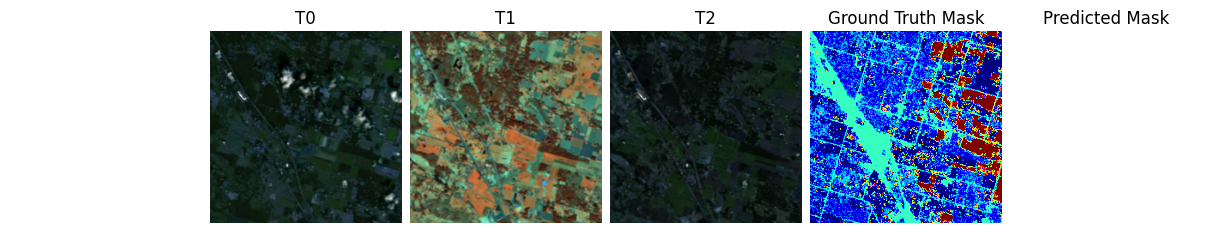

In [27]:
# Plot samples and respective predictions

for i in range(BATCH_SIZE):
    try:
        sample = {key: batch[key][i] for key in batch}
        sample["prediction"] = preds[0][0][i].cpu().numpy()
        
        data_module.predict_dataset.plot(sample)
    except Exception as e:
        print(f"Error plotting sample {i}: {e}")
        continue